# ✂️ Synthetic Data Generation

The second data set is generated using clipped images of drones (object) placed onto a real background image (canvas) in a cut-and-paste fashion.

Number of images:
- `Training = 20264`
- `Validation = 4304`

Test data will reuse the original data set for comparison.

In [1]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

from src import utils

## 1. Canvas Images

Reusing the same canvas images for training and validation sets as previously split.

In [2]:
# Read the lists back in
trn_canvases = pd.read_csv(os.path.join(utils.EXTERNAL_DATA_DIR, "canvas", "trn_cache.csv"))
val_canvases = pd.read_csv(os.path.join(utils.EXTERNAL_DATA_DIR, "canvas", "val_cache.csv"))

print(f"{len(trn_canvases)} training image canvases and {len(val_canvases)} validation image canvases.")

61 training image canvases and 16 validation image canvases.


## 2. Objects

In [3]:
# Get the list of 3D model files
object_paths = utils.files.get_image_files(os.path.join(utils.EXTERNAL_DATA_DIR, "drone_clipart"))

## 3. Data Generation

### a. Training Data

In [9]:
# Set the number of training data images to create
training_total = 5066  # Actual = 5066

In [5]:
# Set the data directory
train_data_dir = os.path.join(utils.INTERIM_DATA_DIR, "clip_art_data", "train")

# Create the folders if they don't exist
os.makedirs(train_data_dir, exist_ok=True)

In [10]:
# Set a random number generator seed for reproducibility
rng = np.random.default_rng(seed=555)

# Loop to create training data equal to the total number specified
for i in range(training_total):
    
    # Create a base file name for the final image and annotation file
    base_filename = f"clip_art_img_{i:05d}"
    
    if i % 100 == 0:
        print(f"Creating training image {i} of {training_total}")

    # Randomly select a canvas image
    canvas_path = rng.choice(trn_canvases)[0]
    canvas = Image.open(canvas_path)
    canvas_size = canvas.size

    # Select a random number of models to place in the canvas
    num_models = rng.integers(low=1, high=6)

    # Loop for each model to be placed
    for m in range(num_models):
        # Randomly select a 3D model file
        obj_path = rng.choice(object_paths)
        # Load the object image
        obj_img = Image.open(obj_path)
            
        # Set a seed for the model randomization
        obj_seed = (i + 1) * 100 + (m + 1) * 10
        
        # Apply random number of transformations to the object
        num_transforms = rng.integers(low=0, high=4)
        # Loop for the number of transformations
        for t in range(num_transforms):
            obj_img = utils.synth.rng_transform(obj_img, seed = obj_seed + t)
        
        # Scale the object to a random size
        # Scale is a factor of the canvas size
        scale_factor = utils.synth.rng_scale(seed=obj_seed)
        obj_img = utils.synth.scale_obj(obj_img, scale_factor, canvas_size)
        # Width and height ratios for annotation
        obj_width = obj_img.size[0] / canvas_size[0]
        obj_height = obj_img.size[1] / canvas_size[1]

        # Randomly position the object within the canvas
        coordinates_topleft = utils.synth.rng_position(obj_img.size, canvas_size, seed=obj_seed)
        # Calculate the center coordinates for annotation
        x_center = (coordinates_topleft[0] + obj_img.size[0] / 2) / canvas_size[0]
        y_center = (coordinates_topleft[1] + obj_img.size[1] / 2) / canvas_size[1]
        
        # Paste the object onto the canvas
        canvas.paste(obj_img, coordinates_topleft)

        # Add the annotation for the object to the annotation text file
        ann = [0, x_center, y_center, obj_width, obj_height]  # Class is 0 since all objects are the same class
        with open(os.path.join(train_data_dir, f"{base_filename}.txt"), "a") as ann_file:
            ann_file.write(" ".join([str(a) for a in ann]) + "\n")
            
    # Save the final image
    canvas.save(os.path.join(train_data_dir, f"{base_filename}.png"))

Creating training image 0 of 5066
Creating training image 100 of 5066
Creating training image 200 of 5066
Creating training image 300 of 5066
Creating training image 400 of 5066
Creating training image 500 of 5066
Creating training image 600 of 5066
Creating training image 700 of 5066
Creating training image 800 of 5066
Creating training image 900 of 5066
Creating training image 1000 of 5066
Creating training image 1100 of 5066
Creating training image 1200 of 5066
Creating training image 1300 of 5066
Creating training image 1400 of 5066
Creating training image 1500 of 5066
Creating training image 1600 of 5066
Creating training image 1700 of 5066
Creating training image 1800 of 5066
Creating training image 1900 of 5066
Creating training image 2000 of 5066
Creating training image 2100 of 5066
Creating training image 2200 of 5066
Creating training image 2300 of 5066
Creating training image 2400 of 5066
Creating training image 2500 of 5066
Creating training image 2600 of 5066
Creating trai

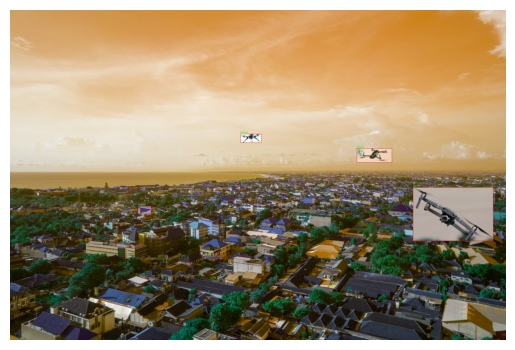

In [11]:
# Check bounding boxes
trn_imgs = utils.files.get_image_files(train_data_dir)
ann_files = utils.files.get_annotation_files(train_data_dir)

random_img = rng.integers(low=0, high=len(trn_imgs))
trn_img = trn_imgs[random_img]
ann_file = ann_files[random_img]

bboxes = utils.label_data.read_bbox_file(ann_file)

xxyy_bboxes = []
for bbox in bboxes:
    xxyy_bbox = utils.label_data.bbox_xxyy(bbox)
    xxyy_bboxes.append(xxyy_bbox)

bbox_img = utils.image_data.draw_bbox(trn_img, xxyy_bboxes)

plt.imshow(bbox_img)
plt.axis('off')
plt.show()

### b. Validation Data

In [12]:
# Set the number of validation data images to create
validation_total = 1076  # Actual = 1076

In [13]:
# Set the data directory
val_data_dir = os.path.join(utils.INTERIM_DATA_DIR, "clip_art_data", "val")

# Create the folders if they don't exist
os.makedirs(val_data_dir, exist_ok=True)

In [14]:
# Set a random number generator seed for reproducibility
rng = np.random.default_rng(seed=54321)

# Loop to create training data equal to the total number specified
for i in range(validation_total):
    
    # Create a base file name for the final image and annotation file
    base_filename = f"clip_art_img_v_{i:05d}"
    
    if i % 100 == 0:
        print(f"Creating validation image {i} of {validation_total}")

    # Randomly select a canvas image
    canvas_path = rng.choice(val_canvases)[0]
    canvas = Image.open(canvas_path)
    canvas_size = canvas.size

    # Select a random number of models to place in the canvas
    num_models = rng.integers(low=1, high=6)

    # Loop for each model to be placed
    for m in range(num_models):
        # Randomly select a 3D model file
        obj_path = rng.choice(object_paths)
        # Load the object image
        obj_img = Image.open(obj_path)
            
        # Set a seed for the model randomization
        obj_seed = (i + 1) * 1000 + (m + 1) * 100
        
        # Apply random number of transformations to the object
        num_transforms = rng.integers(low=0, high=4)
        # Loop for the number of transformations
        for t in range(num_transforms):
            obj_img = utils.synth.rng_transform(obj_img, seed = obj_seed + t)
        
        # Scale the object to a random size
        # Scale is a factor of the canvas size
        scale_factor = utils.synth.rng_scale(seed=obj_seed)
        obj_img = utils.synth.scale_obj(obj_img, scale_factor, canvas_size)
        # Width and height ratios for annotation
        obj_width = obj_img.size[0] / canvas_size[0]
        obj_height = obj_img.size[1] / canvas_size[1]

        # Randomly position the object within the canvas
        coordinates_topleft = utils.synth.rng_position(obj_img.size, canvas_size, seed=obj_seed)
        # Calculate the center coordinates for annotation
        x_center = (coordinates_topleft[0] + obj_img.size[0] / 2) / canvas_size[0]
        y_center = (coordinates_topleft[1] + obj_img.size[1] / 2) / canvas_size[1]
        
        # Paste the object onto the canvas
        canvas.paste(obj_img, coordinates_topleft)

        # Add the annotation for the object to the annotation text file
        ann = [0, x_center, y_center, obj_width, obj_height]  # Class is 0 since all objects are the same class
        with open(os.path.join(val_data_dir, f"{base_filename}.txt"), "a") as ann_file:
            ann_file.write(" ".join([str(a) for a in ann]) + "\n")
            
    # Save the final image
    canvas.save(os.path.join(val_data_dir, f"{base_filename}.png"))

Creating validation image 0 of 1076
Creating validation image 100 of 1076
Creating validation image 200 of 1076
Creating validation image 300 of 1076
Creating validation image 400 of 1076
Creating validation image 500 of 1076
Creating validation image 600 of 1076
Creating validation image 700 of 1076
Creating validation image 800 of 1076
Creating validation image 900 of 1076
Creating validation image 1000 of 1076
